# SVD and NMF based movie recommender systems

In [196]:
# Load libraries and data

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import ndcg_score, average_precision_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise import accuracy
from surprise.model_selection import cross_validate
#from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import warnings; warnings.simplefilter('ignore')

In [244]:
reader = Reader()
ratings = pd.read_csv('ratings_small.csv')
del ratings['timestamp'] # we don't need this colmn, so we delete it.

In [247]:
# Before we do some work on it, let us check the data parameters:
ratings['userId'].nunique() # number of users
ratings.shape 
ratings['movieId'].nunique() # number of movies


9066

So, approximate size of our matrix for movie estimation is 6080000 and we have 100004 ratings. The absolute proportion rate is 1.64%

In [202]:
# The proportion of number of rates to whole number of pairs usr-movie
print(round(len(ratings['rating'])/(n_usr*n_mv)*100, 2),"%")


1.64 %


In [248]:
# Now we will check how many ratings we have and the mean number of 
# movie estimation from each user

Text(0.5, 1.0, 'Rating distribution')

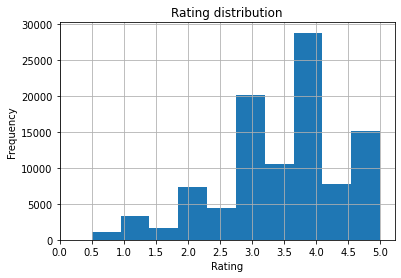

In [21]:
ratings['rating'].hist()
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 5.5, 0.5))
plt.title('Rating distribution')

min =  20
max =  2391


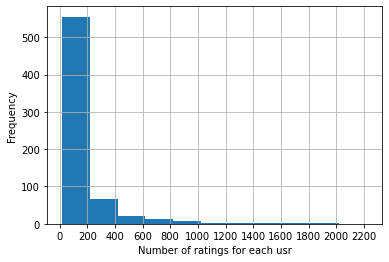

In [204]:
# Average number of movies rated by one user
freq_df = ratings['userId'].value_counts()
width = 200
freq_df.hist(bins = np.arange(min(freq_df), max(freq_df), width))
plt.xlabel('Number of ratings for each usr')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, max(freq_df), width))
print('min = ',min(freq_df))
print('max = ',max(freq_df))

In [205]:
freq_df = freq_df[int(freq_df.quantile(0.1)):int(freq_df.quantile(0.9))]
print('mean = ', freq_df.mode(), ' mode = ', freq_df.mean())

mean =  0    138
dtype: int64  mode =  200.77926421404683


In [249]:
# getting data in propear form
from scipy.sparse import random as sparse_random



row = ratings['userId'].tolist()

col = ratings['movieId'].tolist()

data = ratings['rating'].tolist()

Data = csr_matrix((data, (row, col)), shape=(max(row)+1, max(col)+1)).toarray()

Data = Data[1:] # del first zero row

# Let's check the sparcity of a matrix:
print(len(Data.nonzero()[0]) / float(Data.shape[0] * Data.shape[1])*100, '%')

# And the proportion of number of rates to whole number of pairs usr-movie
print(round(len(ratings['rating'])/(n_usr*n_mv)*100, 2),"%")



0.09090409138404579 %
1.64 %


This indicates the amount of present ratings.

# SVD Factorization


Using sklearn library we made a single-value decomposition

In [206]:
svd = TruncatedSVD(n_components=1)
U_Sigma = svd.fit_transform(Data)
VT = svd.components_

In [207]:
A = U_Sigma.dot(VT)
A.shape

(671, 163950)

In [208]:
A = A.round(2)
A

array([[-0.  ,  0.09,  0.03, ...,  0.  ,  0.  ,  0.  ],
       [-0.  ,  0.75,  0.3 , ...,  0.  ,  0.  ,  0.02],
       [-0.  ,  0.62,  0.25, ...,  0.  ,  0.  ,  0.01],
       ...,
       [-0.  ,  0.29,  0.12, ...,  0.  ,  0.  ,  0.01],
       [-0.  ,  0.52,  0.21, ...,  0.  ,  0.  ,  0.01],
       [-0.  ,  1.65,  0.67, ...,  0.  ,  0.  ,  0.03]])

In [209]:
# Using this function we return top movie id's based on our prediction
def predict_movie_rate(matrix=A, usrId=1, movieId = 1):
    return A[usrId][movieId], movieId

def predict_top_n_movies(n = 10, matrix = A, usrId=1):
    return sorted([predict_movie_rate(matrix, usrId, movieId) for movieId in range(n_mv)], reverse = True)[:n]

predict_top_n_movies(n = 10, matrix = A, usrId=1)

[(1.02, 296),
 (0.98, 356),
 (0.96, 318),
 (0.94, 260),
 (0.93, 593),
 (0.87, 2571),
 (0.87, 1196),
 (0.84, 1270),
 (0.83, 1198),
 (0.8, 527)]

In [210]:
svd.get_params()

{'algorithm': 'randomized',
 'n_components': 1,
 'n_iter': 5,
 'random_state': None,
 'tol': 0.0}

In [28]:
# Let's take first 10 users and first 10 films for each and apply Mean Average Precision
# In the future take 10 random users and may be other number of movies

# problem: make universal for any feature number
def rate(usr = 10, mv = 10):
    dic = dict()
    i = 0
    while (ratings['userId'][i] != usr+1):
        element = ratings['movieId'][i], ratings['rating'][i]
        if ratings['userId'][i] not in dic:
            dic[ratings['userId'][i]] = [element]
        else:
            dic[ratings['userId'][i]].append(element)
        i += 1

    for key in dic:
        dic[key] = sorted(dic[key], key = lambda x:x[1], reverse = True)[1:mv+1]
        dic[key] = [dic[key][i][0] for i in range(len(dic[key]))]
    return dic

check = rate(usr = 10, mv = 10)
check

{1: [1953, 2105, 1339, 1029, 1061, 2150, 3671, 31, 1371, 2455],
 2: [39, 150, 222, 265, 266, 551, 585, 589, 590, 592],
 3: [356, 1197, 2959, 3949, 296, 1721, 48783, 50068, 110, 778],
 4: [112, 141, 260, 296, 349, 356, 357, 364, 480, 541],
 5: [1035, 1380, 2081, 33166, 277, 500, 1485, 1784, 1923, 2694],
 6: [1204, 5952, 7153, 1250, 1259, 1276, 1285, 2761, 8874, 111],
 7: [260, 318, 720, 745, 1148, 1196, 1198, 1210, 1223, 1225],
 8: [47, 50, 318, 527, 543, 858, 1625, 1777, 1961, 2329],
 9: [527, 534, 608, 1059, 1682, 1784, 2571, 1, 17, 318],
 10: [1358, 1611, 1719, 1923, 2344, 2571, 2826, 2926, 152, 318]}

In [212]:
def predict_rate(usr = 10, mv = 10):
    pr_dic = dict()
    
    for i in range(1, usr):
        for j in range(1, len(transformed)):
        
            element = j, round(transformed[i][0]*transformed[j][0], 1)
            if i not in pr_dic:
                pr_dic[i] = [element]
            else:
                pr_dic[i].append(element)
    
    print(sorted(pr_dic[1], key = lambda x:x[1], )[:20])
    print(sorted(pr_dic[2], key = lambda x:x[1], )[:20])

    for key in pr_dic:
        pr_dic[key] = sorted(pr_dic[key], key = lambda x:x[1], reverse = True)[1:mv+1]
       
    return pr_dic



In [213]:
#Now, let's get the RMSE for our NSVD algorithm:
from sklearn.metrics import mean_squared_error

predicted_SVD = A[Test_matrix.nonzero()].flatten()    
real_SVD = Test_matrix[Test_matrix.nonzero()].flatten() 
np.sqrt(mean_squared_error(predicted_SVD, real_SVD))


3.0964271533374723

In [214]:
# NCDG metrics:

from sklearn.metrics import ndcg_score 

ndcg_score([real_SVD], [predicted_SVD])

0.978169480322486

In [236]:
# Mean average precision metrics:

from sklearn.metrics import average_precision_score
map_arr_SVD = [0 if i<2 else 1 for i in real_SVD]
svd_pres = average_precision_score(map_arr_SVD, predicted_SVD)

Let's recall that to achieve the best approximation our matrix have to be close to 0, therefore this values mean that our system works very well.

# NMF factorization



Non-Negative Matrix Factorization.

In [216]:
nmf = NMF(n_components=20)

nmf.fit(Data)
W = nmf.transform(Data)
M = nmf.components_.T

Pred_data = M.dot(W.T) 
Pred_data = Pred_data.T

Pred_data.round(2)

array([[0.  , 0.05, 0.02, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.68, 1.58, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.33, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.36, 0.14, ..., 0.  , 0.  , 0.  ],
       [0.  , 1.15, 0.4 , ..., 0.  , 0.  , 0.  ],
       [0.  , 3.36, 0.29, ..., 0.  , 0.  , 0.  ]])

Let's validate on the same test and trainset:

Splitting into two sets(Training and Testing)

In [225]:

X = ratings[['userId', 'movieId']].values

y = ratings['rating'].values
#train_test_split(X, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_test

array([4. , 3.5, 5. , ..., 2. , 4. , 3. ])

In [219]:
#test
r  = X_test[:,0]
c  = X_test[:,1]
d = y_test
Test_matrix =  csr_matrix((d, (r, c)), shape=(max(r)+1, max(c)+1)).toarray()
Test_matrix =  Test_matrix [1:] 
Test_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [220]:
#Now, let's get the RMSE for our NMF algorithm:
from sklearn.metrics import mean_squared_error

predicted = Pred_data[Test_matrix.nonzero()].flatten()    
real = Test_matrix[Test_matrix.nonzero()].flatten() 
np.sqrt(mean_squared_error(predicted, real))


2.5349280506087943

In [221]:
# NCDG metrics:

from sklearn.metrics import ndcg_score 

ndcg_score([real], [predicted])


0.9826583668972942

This result is actually really good! With the best posible score being 1.

In [227]:
# Mean average precision metrics:

from sklearn.metrics import average_precision_score
map_arr = [0 if i<2 else 1 for i in real]
nmf_pres = average_precision_score(map_arr, predicted)


Naturally, general average precision score is also very good.


We also evaluated the precision-recall curve

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.96')

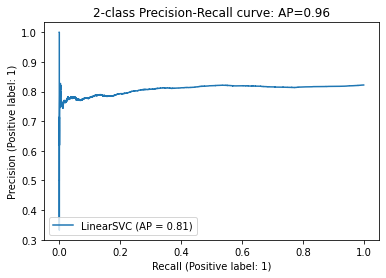

In [238]:
# Precision-recall curve 

from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

random_state = np.random.RandomState(0)
classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, np.where(y_train > 2.5, 1, 0))
y_score = classifier.decision_function(X_test)


disp = plot_precision_recall_curve(classifier, X_test, np.where(y_test > 2.5, 1, 0))
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(svd_pres))